<a href="https://colab.research.google.com/github/Ryul-K/test1/blob/master/mask_detection_trainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참고자료 불러오기 블로그 주소:

In [3]:
!git clone https://github.com/gachonyws/face-mask-detector.git

Cloning into 'face-mask-detector'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1302 (delta 0), reused 0 (delta 0), pack-reused 1298
Receiving objects: 100% (1302/1302), 74.61 MiB | 45.13 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# 하드웨어 가속(GPU사용법) : 좌측 상단 "런타임" -> "런타임 유형 변경" -> "None"으로 되어있으면 "GPU"로 변경후 저장

# TrainModel_MobileNetV2

In [36]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import seaborn as sns
import tensorflow as tf


In [37]:

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
# 	default="mask_detector.model",
# 	help="path to output face mask detector model")
# args = vars(ap.parse_args())

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

dataset = "/content/face-mask-detector/dataset"# dataset 폴더 경로 적어주기

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


[INFO] loading images...


(1376, 224, 224, 3) (1376, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


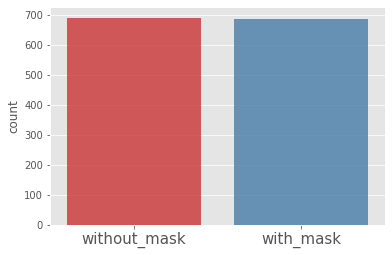

In [43]:
X = data
Y = labels

print(X.shape, Y.shape)



ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask'], rotation=0, fontsize=15)
plt.show()

In [38]:

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [39]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...


In [40]:

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


# serialize the model to disk
print("[INFO] saving mask detector model...")

model_dir = "mask_detector.model" # please input "path to output face mask detector model"

model.save(model_dir, save_format="h5")


[INFO] training head...
Epoch 1/20
34/34 [==============================] - 11s 337ms/step - loss: 0.3902 - accuracy: 0.8174 - val_loss: 0.1055 - val_accuracy: 0.9855
Epoch 2/20
34/34 [==============================] - 11s 311ms/step - loss: 0.1217 - accuracy: 0.9663 - val_loss: 0.0461 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 11s 313ms/step - loss: 0.0795 - accuracy: 0.9798 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 4/20
34/34 [==============================] - 10s 307ms/step - loss: 0.0613 - accuracy: 0.9878 - val_loss: 0.0218 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 10s 307ms/step - loss: 0.0445 - accuracy: 0.9888 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 10s 308ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 11s 309ms/step - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.012

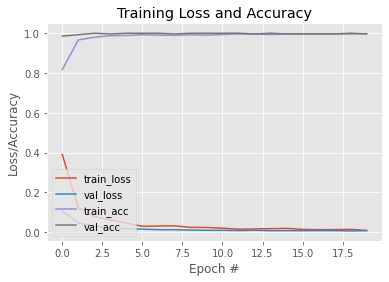

In [42]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png") # you can change the "path to output loss/accuracy plot"

# TrainModel_inceptionV3

In [69]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os




In [70]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

dataset = "/content/face-mask-detector/dataset"# dataset 폴더 경로 적어주기

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

print("[INFO] loading SUCCESS!")
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...
[INFO] loading SUCCESS!


(1376, 224, 224, 3) (1376, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


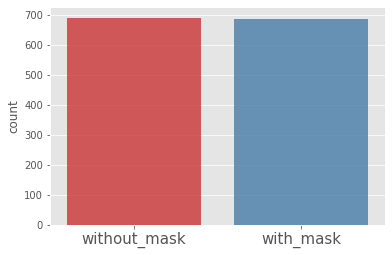

In [71]:
X = data
Y = labels

print(X.shape, Y.shape)



ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask'], rotation=0, fontsize=15)
plt.show()

In [72]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3)) 
# pre_trained_model.summary()
# include_top : 가장 상단의 fully connected 계층들을 포함 시킬지의 여부입니다.
# weight : 케라스에서 미리 pretraining 시켜놓은 weight을 사용 할 것인지 여부입니다.
# input_shape : (img_width, img_height, img_channel(RGB))



for layer in pre_trained_model.layers:       #transfer learning(전이학습모델) ; inceptionV3 model을 불러와 기존 가중치를 학습하지않는다
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# inceptionV3의 'mixed7' 레이어를 마지막 레이어로써 설정하고 해당 레이어의 아웃풋을 저장한다.
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output
print(last_output)    

#feature engineering -> 선형결합 -> batch normalization -> activation func -> dropdout   세팅
x = tf.keras.layers.Flatten()(last_output)   # inceptionV3 모델의 mixed7레이어의 아웃풋을 이미지 데이터 1차원 처리후
x = tf.keras.layers.Dense(1024, activation='relu')(x) # input처리, 활성화함수: relu
x = tf.keras.layers.Dropout(0.3)(x)  # 30% 드랍아웃
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(2, activation='softmax')(x) # 최종 결과 인덱싱이 without, with, 2분류

model_inceptionV3 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x) 

model_inceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #adam, adagrad, rmsprop
model_inceptionV3.summary()

Last layer output shape : (None, 12, 12, 768)
Tensor("mixed7/concat_1:0", shape=(None, 12, 12, 768), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_110 (BatchN (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_110 (Activation)     (None, 111, 111, 32) 0           batch

In [73]:
# Normalizing 픽셀은 0 ~ 255값을 가집니다. 그리고 학습을 하기엔 0~1사이의 소수가 필요하구요. 그래서 256으로 나누어 주었습니다.

X = X / 255

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/face-mask-detector/model_inceptionV3-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    verbose=0)

history = model_inceptionV3.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    validation_split=0.1)

Epoch 1/20
31/31 [==============================] - 4s 113ms/step - loss: 8.2906 - acc: 0.5232 - val_loss: 0.4265 - val_acc: 0.8091
Epoch 2/20
31/31 [==============================] - 3s 88ms/step - loss: 0.6255 - acc: 0.7525 - val_loss: 0.4287 - val_acc: 0.7909
Epoch 3/20
31/31 [==============================] - 3s 89ms/step - loss: 0.3975 - acc: 0.8283 - val_loss: 0.3130 - val_acc: 0.9091
Epoch 4/20
31/31 [==============================] - 3s 89ms/step - loss: 0.3804 - acc: 0.8354 - val_loss: 0.3700 - val_acc: 0.8273
Epoch 5/20
31/31 [==============================] - 3s 89ms/step - loss: 0.3161 - acc: 0.8768 - val_loss: 0.2916 - val_acc: 0.9182
Epoch 6/20
31/31 [==============================] - 3s 90ms/step - loss: 0.2819 - acc: 0.8788 - val_loss: 0.2631 - val_acc: 0.8909
Epoch 7/20
31/31 [==============================] - 3s 90ms/step - loss: 0.3124 - acc: 0.8646 - val_loss: 0.2342 - val_acc: 0.9000
Epoch 8/20
31/31 [==============================] - 3s 90ms/step - loss: 0.2826 - 

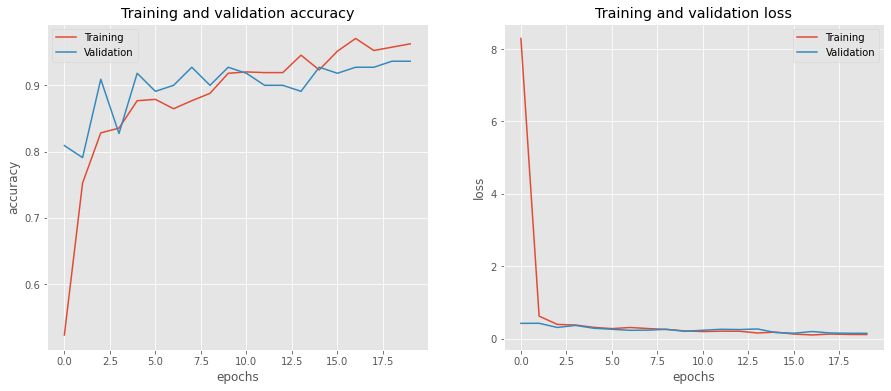

In [74]:
# PLOT LOSS AND ACCURACY
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [75]:
model_dir = "mask_detector_inceptionV3.model" # please input "path to output face mask detector model"

model.save(model_dir, save_format="h5")

# TrainModel_Sequential


In [76]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics



In [77]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

dataset = "/content/face-mask-detector/dataset"# dataset 폴더 경로 적어주기

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

print("[INFO] loading SUCCESS!")
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...
[INFO] loading SUCCESS!


(1376, 224, 224, 3) (1376, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


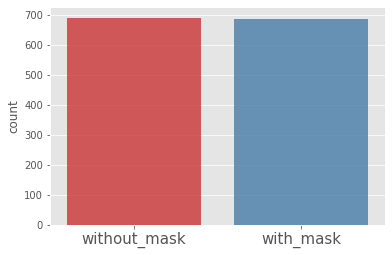

In [78]:
X = data
Y = labels

print(X.shape, Y.shape)



ax = sns.countplot(np.argmax(Y, axis=1), palette="Set1", alpha=0.8)
ax.set_xticklabels(['without_mask', 'with_mask'], rotation=0, fontsize=15)
plt.show()

In [79]:
X = X / 255

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [80]:
print(X_train.shape, Y_train.shape) # 224, 224, 3 -> 이게 펼쳐져서 총 224x224x3 열로 만들어져야 해요

(1100, 224, 224, 3) (1100, 2)


In [81]:
X_train = X_train.reshape(-1, 224*224*3)
X_test = X_test.reshape(-1, 224*224*3)

print(X_train.shape, Y_train.shape) # 224, 224, 3 -> 이게 펼쳐져서 총 224x224x3 열로 만들어져야 해요

(1100, 150528) (1100, 2)


In [82]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=150528, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) # layers.ELU or layers.LeakyReLU
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) # layers.ELU or layers.LeakyReLU
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=2, activation='softmax')) # 0~9 
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               38535424  
_________________________________________________________________
batch_normalization_204 (Bat (None, 256)               1024      
_________________________________________________________________
activation_204 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_205 (Bat (None, 512)               2048      
_________________________________________________________________
activation_205 (Activation)  (None, 512)              

In [83]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [84]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_split=0.2) 

Epoch 1/20
9/9 [==============================] - 1s 58ms/step - loss: 0.6654 - categorical_accuracy: 0.7193 - val_loss: 0.5833 - val_categorical_accuracy: 0.6636
Epoch 2/20
9/9 [==============================] - 0s 44ms/step - loss: 0.3595 - categorical_accuracy: 0.8500 - val_loss: 0.4865 - val_categorical_accuracy: 0.7500
Epoch 3/20
9/9 [==============================] - 0s 43ms/step - loss: 0.2996 - categorical_accuracy: 0.8795 - val_loss: 0.4368 - val_categorical_accuracy: 0.7682
Epoch 4/20
9/9 [==============================] - 0s 44ms/step - loss: 0.2424 - categorical_accuracy: 0.9034 - val_loss: 0.3662 - val_categorical_accuracy: 0.8545
Epoch 5/20
9/9 [==============================] - 0s 41ms/step - loss: 0.1796 - categorical_accuracy: 0.9341 - val_loss: 0.3007 - val_categorical_accuracy: 0.9182
Epoch 6/20
9/9 [==============================] - 0s 42ms/step - loss: 0.1439 - categorical_accuracy: 0.9443 - val_loss: 0.2749 - val_categorical_accuracy: 0.9091
Epoch 7/20
9/9 [======

In [85]:
result = model.evaluate(X_test, Y_test, batch_size=100)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

3/3 [==============================] - 0s 14ms/step - loss: 0.2051 - categorical_accuracy: 0.9312
loss (cross-entropy) : 0.2051488310098648
test accuracy : 0.9311594367027283


In [86]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

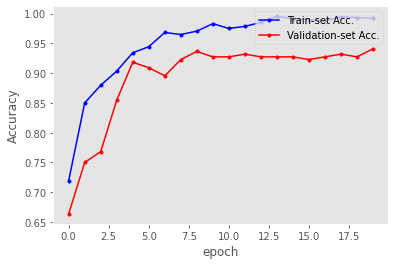

In [87]:
val_acc = history.history['val_categorical_accuracy']
acc = history.history['categorical_accuracy']

import numpy as np
import matplotlib.pyplot as plt

x_len = np.arange(len(acc))
plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [88]:
model_dir = "mask_detector_Sequential.model" # please input "path to output face mask detector model"

model.save(model_dir, save_format="h5")